In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/RL/DRL-Object-Detection-main/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/RL/DRL-Object-Detection-main


In [2]:
from utils.agent import *
from utils.dataset import read_voc_dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import numpy as np
%reload_ext autoreload
%autoreload 2

## 1. Load dataset and visualize

In [3]:
train_loader2007, val_loader2007 = read_voc_dataset(path="." ,year='2007', download=False)
#train_loader2012, val_loader2012 = read_voc_dataset(path="." ,year='2012')


In [4]:
datasets_per_class = sort_class_extract([train_loader2007,])

  0%|          | 0/2501 [00:00<?, ?it/s]

In [5]:
cat_dataset = datasets_per_class['cat']
len(cat_dataset)

166

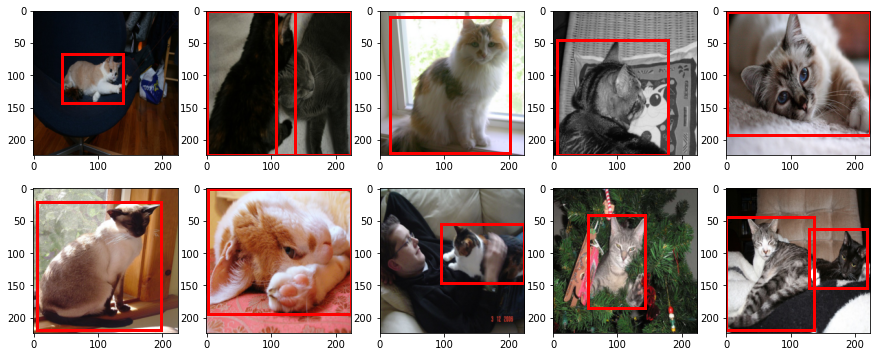

In [6]:
t = 1
plt.figure(figsize=[15,6])
indexes = []
for i in list(cat_dataset.keys())[:10]:
    indexes.append(i)
    image = cat_dataset[i][0][0]
    plt.subplot(2,5,t)
    plt.imshow(image.permute([1,2,0]))
    
    for j in range(1,len(cat_dataset[i][0])):
        gt = cat_dataset[i][0][j][0]
        image_size = cat_dataset[i][0][j][1]
    
        origin_width, origin_height = int(image_size['width']), int(image_size['height'])
        real_width, real_height = 224, 224
        width_ratio, height_ratio = real_width/origin_width, real_height/origin_height

        bdbox = np.array([gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax']]).astype('float')
        bdbox = (bdbox * [width_ratio, height_ratio, width_ratio, height_ratio]).astype('int')

    
        plt.gca().add_patch(plt.Rectangle((bdbox[0], bdbox[1]), 
                                          bdbox[2]-bdbox[0], bdbox[3]-bdbox[1], 
                                          fill=False, edgecolor='r', linewidth=3))
    t += 1

## 2. Training

In [18]:
def train(model_type, eps):
  agents=[]
  for i in tq.tqdm(range(len(classes))):
      classe = classes[i]
      print("Classe "+str(classe)+"...")

      if model_type=='org':
        agent = Agent(classe, alpha=0.2, num_episodes=eps, load=False, model_name='vgg16_org', n_actions=9)
      elif model_type=='3_step':
        agent = Agent_3alpha(classe, alpha=0.2, num_episodes=eps, nu=10.0,threshold=0.65, load=False, model_name='vgg16_3step', n_actions=25)

      agent.train(datasets_per_class[classe])
      agents.append(agent)
      del agent
      torch.cuda.empty_cache()
  return agents
  

In [19]:
agent_3step = train('3_step',15)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Classe cat...
Episode 0
Saved
Complete
Episode 1
Saved
Complete
Episode 2
Saved
Complete
Episode 3
Saved
Complete
Episode 4
Saved
Complete
Episode 5
Saved
Complete
Episode 6
Saved
Complete
Episode 7
Saved
Complete
Episode 8
Saved
Complete
Episode 9
Saved
Complete
Episode 10
Saved
Complete
Episode 11
Saved
Complete
Episode 12
Saved
Complete
Episode 13
Saved
Complete
Episode 14
Saved
Complete


In [9]:
agent_org = train('org',15)[0]

[autoreload of utils.agent failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/gdrive/My Drive/RL/DRL-Object-Detection-main/utils/agent.py", line 763
    if not load:
    ^
IndentationError: unexpected indent
]


  0%|          | 0/1 [00:00<?, ?it/s]

Classe cat...
Episode 0


KeyboardInterrupt: ignored

## 3. Test

### Test on training set

In [20]:
from utils.tools import classes
def test(model, model_name, data_set):

  # Test on whole dataset to get result metrics
  torch.cuda.empty_cache()
  results = {}
  for i in classes:
    results[i] = []

  for i in tq.tqdm(range(len(classes))):
    classe = classes[i]
    print("Class "+str(classe)+"...")
    agent = model
    res = agent.evaluate(cat_dataset)
    results[classe] = res


In [21]:
test(agent_3step, 'vgg16_3step', cat_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Class cat...
Predicting boxes...


/content/gdrive/My Drive/RL/DRL-Object-Detection-main/utils/agent.py:713: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if (action-1)//8 == 0: alpha = self.alpha * 0.5
/content/gdrive/My Drive/RL/DRL-Object-Detection-main/utils/agent.py:714: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  elif (action-1)//8 == 1: alpha = self.alpha * 1.

Computing recall and ap...
Final result : 
              0.4        0.5        0.6
ap      80.104712  73.298429  69.109948
recall  80.104712  73.298429  69.109948


In [ ]:
test(agent_org, 'vgg16_org', cat_dataset)

### Test on validation set

In [ ]:
datasets_per_class_val = sort_class_extract([val_loader2007])

In [15]:
def visualize(img_num, agent):
  toy_val = {}
  for i,(k,v) in enumerate(datasets_per_class['cat'].items()):
      if i==img_num: 
        toy_val[k]=v
        break

  for key, value in toy_val.items():
    image, gt_boxes = extract(key, toy_val)
    bbox = agent_3step.predict_multiple_objects(image, plot=True)
    break
  


In [22]:
visualize(8, agent_3step)

In [ ]:
torch.cuda.empty_cache()
model_name='vgg16_org'
agent = Agent(classe, load=True, model_name=model_name)
res = agent.evaluate(datasets_per_class_val['cat'])

In [ ]:
torch.cuda.empty_cache()
model_name='vgg16_3step'
#agent = Agent(classe, load=True, model_name=model_name)
res = agent_3step.evaluate(datasets_per_class_val['cat'])

In [ ]:
ground_truth_boxes